In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import torch
# import minerl
from tqdm import tqdm
import random

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

import collections

from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion

In [335]:
class EnvSamplingWrapper:
    def __init__(self, env):
        self.env = env
        self.obs = env.reset()
        self.step_count = 0
        self.total_reward = 0
    
    def sample(self, count, policy):
        tuples = []
        rewards = []
        for i in range(count):
            self.step_count += 1
            action = policy(self.obs)
            observation, reward, done, info = env.step(action)
            tuples.append((self.obs, action, reward, observation, done))
            self.obs = observation
            self.total_reward += reward
            if done:
                self.obs = env.reset()
                rewards.append((self.total_reward, self.step_count))
                self.total_reward = 0
        
        return tuples, rewards


def prod(x):
    total = 1
    for i in x:
        total *= i
    return total


class DQN_Net(nn.Module):
    def __init__(self, input_size, action_size):
        super().__init__()
#         print(input_size)
        self.net = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.GELU(),
            nn.Linear(16, 16),
            nn.GELU(),
            nn.Linear(16, action_size),
        )
        with torch.no_grad():
            self.net[-1].weight[:,:] = 0
    
    def forward(self, x):
#         print(x.shape)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.net(x)
        return x

    
def dqn_policy(model, obs):
    # scale the obs, change to model shape
    image = torch.from_numpy(to_batch_shape(obs)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        action = torch.argmax(outputs).item()
    
    return action

In [139]:
"""
From https://github.com/rlcode/per/blob/master/SumTree.py
"""
import numpy


# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros(2 * capacity - 1)
        self.data = numpy.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]
    
    def data_idx(self, idx):
        return (idx + self.capacity + 1) % self.capacity
    
    def tree_idx(self, d_idx):
        return d_idx + self.capacity - 1

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1
        return idx

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
    def get_at(self, idx):
        return (idx, self.tree[idx], self.data[self.data_idx(idx)])

In [264]:
# replay buffer. Store (s, a, r, s_n, d) tuples
class PrioritizedReplayBuffer:
    def __init__(self, max_size=1000000, epsilon=0.00001):
        self.tree = SumTree(max_size)
        self.epsilon = epsilon
    
    def add(self, s, a, r, s_n, d):
        self.tree.add(1, (s, a, r, s_n, d))
    
    def sample_batch(self, batch_size):
        batch = []
        for i in range(batch_size):
            item = self.tree.get(random.random() * self.tree.total())
            batch.append(item)
            self.tree.update(item[0], 0) # sample without replacement
        return batch
    
    def add_all(self, sarsd):
        for i in sarsd:
            buffer.add(*i)
    
    def update(self, idx, p):
        self.tree.update(idx, p + self.epsilon)

In [265]:
def sample_training_batch(buffer, batch_size):
    batch = buffer.sample_batch(batch_size)
    s = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    a = np.zeros((batch_size, 1), dtype='int64')
    r = np.zeros((batch_size, 1), dtype='float32')
    s_n = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    d = np.zeros((batch_size, 1), dtype='float32')

    
    for i, data in enumerate(batch):
        x = data[2]
        s[i] = x[0]
        a[i] = x[1]
        r[i] = x[2]
        s_n[i] = x[3]
        d[i] = x[4]
    
    s = torch.from_numpy(s).permute((0, 3, 1, 2)).cuda() / 255
    s_n = torch.from_numpy(s_n).permute((0, 3, 1, 2)).cuda() / 255
    a = torch.from_numpy(a).cuda()
    r = torch.from_numpy(r).cuda()
    d = torch.from_numpy(d).cuda()
    
    return s, a, r, s_n, d, batch

In [412]:
from DotEnvs import *

In [161]:
env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [162]:
buffer = PrioritizedReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [163]:
buffer.sample_batch(1)

[(1008063,
  1.0,
  (array([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          ...,
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]], dtype=uint8),
   1,
   1,
   array([[[0, 0, 0],


In [164]:
sample_training_batch(buffer, 32)

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [165]:
import timeit

In [166]:
timeit.timeit(lambda: sample_training_batch(buffer, 32), number=1000)

1.3541238530306146

In [266]:
def train_batch(model, target, buffer, optimizer):
    # get the inputs
    
    # sample from the buffer and preprocess next qs
    s, a, r, s_n, d, batch = sample_training_batch(buffer, 32)
#     print(d)
    
    # get the next qs
    with torch.no_grad():
        outputs = target(s_n)
        q_n, a_n = torch.max(outputs, 1)
        # Avoid potential broadcast issue
        q_n = q_n.view(-1, 1)
#         print(q_n.shape)
        targets = r * (1.0) + q_n * (1 - d) * 0.99

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    
    # forward + backward + optimize
    outputs = model(s)
#     print(a.shape)
    
    # get the target action to diff the target with
    v = torch.gather(outputs, 1, a)
#     print(v.shape, outputs.shape)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    individual_loss = F.smooth_l1_loss(v, targets, reduction='none')
    loss = torch.mean(individual_loss)

    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
    optimizer.step()
    
    for i, l in enumerate(individual_loss.detach().reshape(-1).tolist()):
        tree_idx = batch[i][0]
        tree = buffer.tree
        buffer.update(tree_idx, l)
        prev = tree.get_at(tree.tree_idx(tree.data_idx(tree_idx - 1)))
        # skip the wrap around states and terminal states
        if not prev[2] or prev[2][4]:
            continue
#         print(prev[0], prev[1], l)
        buffer.update(prev[0], prev[1] + l)
        
    return loss.detach().item()

In [214]:
train_batch(model, target, buffer, optimizer)

0.005122003145515919

In [267]:
from utilities import soft_update
from basic_dqn import DQN_Policy

In [375]:
def dqn_loop(model, target, env_wrapper, buffer, optimizer, steps, STATS):
    running_loss = None
    running_rew = 0
    
    next_exploration = 0.95
    with tqdm(range(steps), unit="batch") as t:
        for i in t:
            
            if i % 2500 == 0:
                policy = DQN_Policy(model, next_exploration, env_wrapper.env.action_space.sample)
                next_exploration -= 0.05
                next_exploration = max(next_exploration, 0.05)
            
            sarsd, rew = env_wrapper.sample(1, policy)
            buffer.add_all(sarsd)
            STATS['returns'].extend(rew)
            for r in rew:
                running_rew = running_rew * 0.99 + r[0] * 0.01
            
            if (i + 1) % 4 != 0:
                continue

            loss = train_batch(model, target, buffer, optimizer)
            STATS["loss"].append(loss)

            if i % 10000 == 0:
                soft_update(target, model, 1.0)
#             soft_update(target, model, 0.00001)
            if running_loss is None:
                running_loss = loss
            running_loss = running_loss * 0.999 + loss * 0.001
            if (i + 1) % 100 == 0:  # print every N mini-batches
                string = 'loss: %.8f, rew: %.8f' % (
                    running_loss, running_rew
                )
                t.set_postfix_str(string)

In [414]:
model = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
model.cuda()
target = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
target.cuda()
target.eval()
soft_update(target, model, 1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
# optimizer = Lion(model.parameters(), lr=0.00001)

In [415]:
env = SparseDotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [416]:
buffer = PrioritizedReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [417]:
STATS = defaultdict(list)

In [ ]:
dqn_loop(model, target, env_wrapper, buffer, optimizer, 1000000, STATS)

  0%|                                                        | 4/1000000 [00:00<7:35:26, 36.59batch/s]

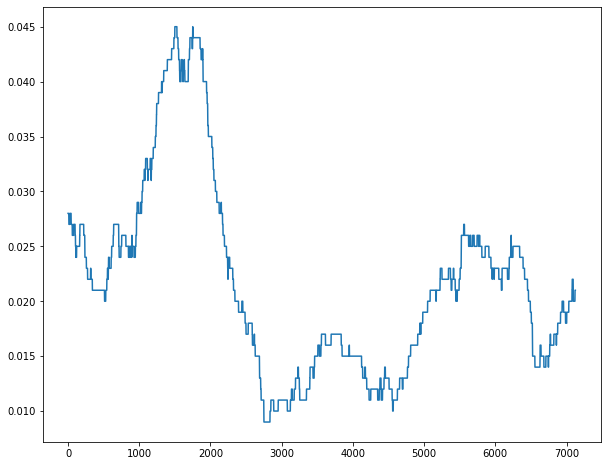

In [455]:
plt.plot(np.convolve(np.asarray([x[0] for x in STATS['returns']]), np.ones((1000,)) / 1000, mode='valid'))

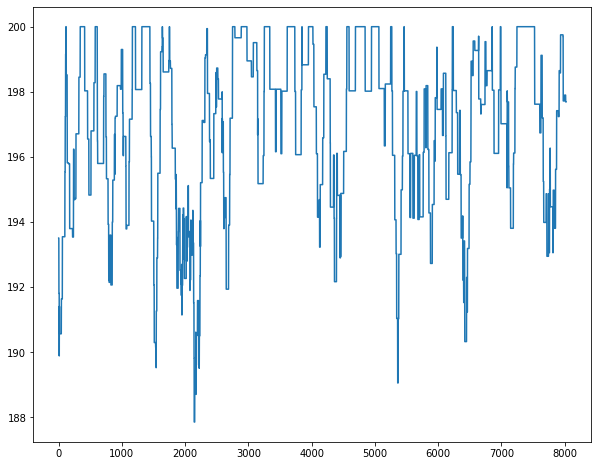

In [456]:
plt.plot(np.convolve(np.convolve(np.asarray([x[1] for x in STATS['returns']]), np.asarray([1, -1]), mode='valid'), np.ones((100,)) / 100, mode='valid'))

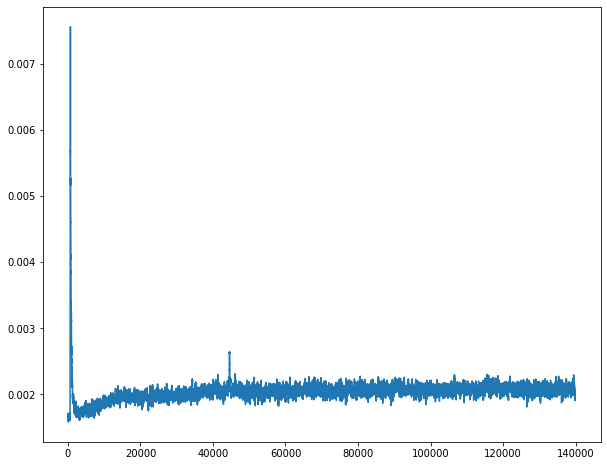

In [453]:
plt.plot(np.convolve(np.asarray(STATS['loss']), np.ones((100,)) / 100, mode='valid')[10000:])

In [436]:
max(buffer.tree.tree[-1000000:])

1.0004825652106573

In [437]:
buffer.tree.total()

111.79495078785286

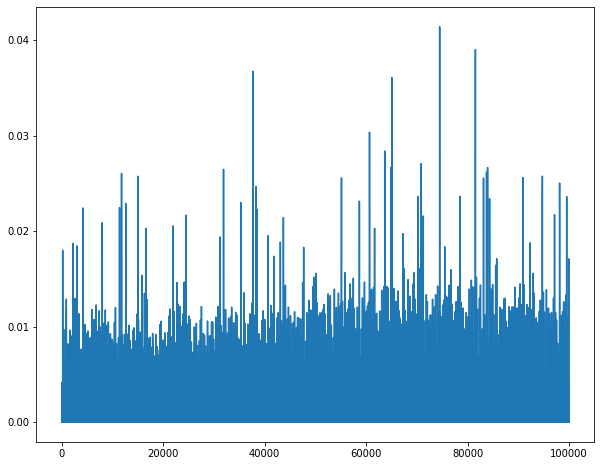

In [438]:
plt.plot(buffer.tree.tree[-1000000:-900000])

In [439]:
sum(buffer.tree.tree[-1000000:-800000])

70.15248916863712

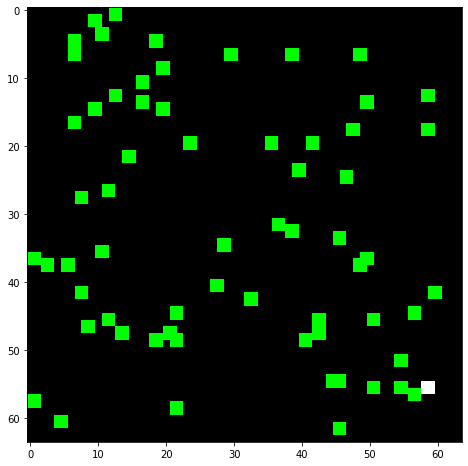

In [404]:
plt.imshow(env.get_obs())

In [409]:
# Well, time to try curiosity learning

In [410]:
# I'll start with RND because it'll be easier than ICM.
# I need two networks, one with fixed random weights, and one to train